# Model Development Notebook

This notebook is designed for developing and testing the machine learning model used for identifying wild animal footprints from images. It includes sections for data loading, preprocessing, model training, and evaluation.

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, MobileNetV3Large, ResNet50V2,DenseNet121
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Average, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model

import cv2

def create_train_val_test_dirs(data, temp_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    """
    Crée une structure de dossiers pour l'entraînement, la validation et le test.
    
    Args:
        data (pd.DataFrame): DataFrame contenant les colonnes 'image_path' et 'species'
        temp_dir (str): Chemin du dossier temporaire où créer les sous-dossiers
        train_size, val_size, test_size (float): Proportions des données pour chaque ensemble
    
    Returns:
        tuple: Chemins des dossiers d'entraînement, validation et test
    """
    import os
    import shutil
    from sklearn.model_selection import train_test_split
    
    # Réinitialiser les dossiers existants
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    
    # Créer les dossiers principaux
    train_dir = os.path.join(temp_dir, 'train')
    val_dir = os.path.join(temp_dir, 'validation')
    test_dir = os.path.join(temp_dir, 'test')
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Obtenir la liste des espèces uniques
    species_list = data['species'].unique()
    
    # Créer un sous-dossier pour chaque espèce dans train, val et test
    for species in species_list:
        os.makedirs(os.path.join(train_dir, species), exist_ok=True)
        os.makedirs(os.path.join(val_dir, species), exist_ok=True)
        os.makedirs(os.path.join(test_dir, species), exist_ok=True)
    
    # Pour chaque espèce, diviser les données
    for species in species_list:
        species_data = data[data['species'] == species]
        
        # Première division: séparer test et non-test
        non_test_data, test_data = train_test_split(
            species_data, 
            test_size=test_size, 
            random_state=42
        )
        
        # Deuxième division: séparer train et validation à partir des données non-test
        train_data, val_data = train_test_split(
            non_test_data,
            test_size=val_size/(train_size+val_size),
            random_state=42
        )
        
        # Copier les images dans les dossiers appropriés
        base_img_dir = '../data/Mammifères/'
        
        # Copier les images d'entraînement
        for _, row in train_data.iterrows():
            src_path = os.path.join(base_img_dir, row['image_path'])
            dst_path = os.path.join(train_dir, species, os.path.basename(row['image_path']))
            shutil.copy(src_path, dst_path)
        
        # Copier les images de validation
        for _, row in val_data.iterrows():
            src_path = os.path.join(base_img_dir, row['image_path'])
            dst_path = os.path.join(val_dir, species, os.path.basename(row['image_path']))
            shutil.copy(src_path, dst_path)
        
        # Copier les images de test
        for _, row in test_data.iterrows():
            src_path = os.path.join(base_img_dir, row['image_path'])
            dst_path = os.path.join(test_dir, species, os.path.basename(row['image_path']))
            shutil.copy(src_path, dst_path)
    
    # Compter et afficher les statistiques
    train_counts = {}
    val_counts = {}
    test_counts = {}
    
    for species in species_list:
        train_counts[species] = len(os.listdir(os.path.join(train_dir, species)))
        val_counts[species] = len(os.listdir(os.path.join(val_dir, species)))
        test_counts[species] = len(os.listdir(os.path.join(test_dir, species)))
    
    print("Répartition des données:")
    print(f"  Entraînement: {sum(train_counts.values())} images")
    print(f"  Validation: {sum(val_counts.values())} images")
    print(f"  Test: {sum(test_counts.values())} images")
    
    return train_dir, val_dir, test_dir

def plot_confusion_matrix(model, generator):
    # Prédire les classes
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = generator.classes[:len(y_pred)]
    
    # Convertir les indices en noms de classes
    idx_to_class = {v: k for k, v in generator.class_indices.items()}
    class_names = [idx_to_class[i] for i in range(len(generator.class_indices))]
    
    # Calculer et normaliser la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Visualisation
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.title('Matrice de confusion normalisée')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Calcul de métriques par classe
    class_accuracy = np.diag(cm) / cm.sum(axis=1)
    for i, (name, acc) in enumerate(zip(class_names, class_accuracy)):
        print(f"{name}: {acc:.2f} ({cm[i].sum()} échantillons)")
        
    return cm, class_names

def preprocess_footprint_image(img_path):
    """
    Prétraitement spécialisé pour les empreintes:
    - Conversion en niveaux de gris
    - Amélioration du contraste
    - Seuillage adaptatif
    - Morphologie pour nettoyer le bruit
    """
    # Charger l'image
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Égalisation d'histogramme pour améliorer le contraste
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)
    
    # Seuillage adaptatif
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 11, 2
    )
    
    # Opérations morphologiques pour nettoyer
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Contours pour isoler l'empreinte principale
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Créer une image masque pour l'empreinte
    mask = np.zeros_like(gray)
    
    # Dessiner uniquement les grands contours (empreintes, pas bruit)
    for cnt in contours:
        if cv2.contourArea(cnt) > 100:  # Seuil arbitraire
            cv2.drawContours(mask, [cnt], 0, 255, -1)
    
    # Appliquer le masque à l'image originale
    result = cv2.bitwise_and(gray, mask)
    
    # Redimensionner pour le modèle
    result = cv2.resize(result, (224, 224))
    
    # Normaliser
    result = result / 255.0
    
    # Convertir en 3 canaux pour le CNN
    result = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)
    
    return result

# Prétraiter toutes les images et les sauvegarder
def preprocess_and_save_dataset(data, output_dir):
    """Prétraite toutes les images et les sauvegarde"""
    os.makedirs(output_dir, exist_ok=True)
    
    for species in data['species'].unique():
        species_dir = os.path.join(output_dir, species)
        os.makedirs(species_dir, exist_ok=True)
    
    for _, row in tqdm(data.iterrows(), total=len(data)):
        species = row['species']
        img_path = os.path.join('../data/Mammifères/', row['image_path'])
        
        # Prétraiter l'image
        processed_img = preprocess_footprint_image(img_path)
        
        if processed_img is not None:
            # Sauvegarder l'image prétraitée
            output_path = os.path.join(output_dir, species, os.path.basename(row['image_path']))
            cv2.imwrite(output_path, (processed_img * 255).astype(np.uint8))

# Créer un modèle d'ensemble pour améliorer les performances
def create_ensemble_model(num_classes, input_shape=(224, 224, 3)):
    # Entrée commune
    input_tensor = Input(shape=input_shape)
    
    # Modèle 1: ResNet50V2
    base1 = ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_tensor)
    x1 = GlobalAveragePooling2D()(base1.output)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.5)(x1)
    output1 = Dense(num_classes, activation='softmax', name='output1')(x1)
    
    # Modèle 2: EfficientNetB0
    base2 = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
    x2 = GlobalAveragePooling2D()(base2.output)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.5)(x2)
    output2 = Dense(num_classes, activation='softmax', name='output2')(x2)
    
    # Modèle 3: DenseNet121
    base3 = DenseNet121(include_top=False, weights='imagenet', input_tensor=input_tensor)
    x3 = GlobalAveragePooling2D()(base3.output)
    x3 = Dense(128, activation='relu')(x3)
    x3 = Dropout(0.5)(x3)
    output3 = Dense(num_classes, activation='softmax', name='output3')(x3)
    
    # Combiner les prédictions
    outputs = Average()([output1, output2, output3])
    
    # Modèle complet
    ensemble = Model(inputs=input_tensor, outputs=outputs)
    
    # Geler tous les modèles de base
    for layer in base1.layers:
        layer.trainable = False
    for layer in base2.layers:
        layer.trainable = False
    for layer in base3.layers:
        layer.trainable = False
        
    return ensemble

# Fonction pour ajouter du bruit aléatoire simulant différentes textures de sol
def add_random_noise(image):
    if np.random.random() > 0.5:  # 50% de chance d'appliquer du bruit
        noise_type = np.random.choice(['gaussian', 'speckle', 'salt_pepper'])
        
        if noise_type == 'gaussian':
            row, col, ch = image.shape
            mean = 0
            sigma = np.random.uniform(0.01, 0.05)
            gauss = np.random.normal(mean, sigma, (row, col, ch))
            noisy = image + gauss
            return np.clip(noisy, 0, 1)
            
        elif noise_type == 'speckle':
            row, col, ch = image.shape
            speckle = np.random.randn(row, col, ch) * np.random.uniform(0.05, 0.1)
            noisy = image + image * speckle
            return np.clip(noisy, 0, 1)
            
        else:  # salt_pepper
            s_vs_p = 0.5
            amount = np.random.uniform(0.01, 0.05)
            noisy = np.copy(image)
            
            # Salt
            num_salt = np.ceil(amount * image.size * s_vs_p)
            coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
            noisy[coords[0], coords[1], :] = 1
            
            # Pepper
            num_pepper = np.ceil(amount * image.size * (1 - s_vs_p))
            coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
            noisy[coords[0], coords[1], :] = 0
            
            return noisy
    
    return image

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
data = pd.read_csv('../data/footprint_dataset.csv')
data.head()

# Après avoir importé les bibliothèques et avant d'utiliser TEMP_DIR, ajoutez:
TEMP_DIR = '../data/temp_dataset'

# Create train, val, test directories using your function
train_dir, val_dir, test_dir = create_train_val_test_dirs(data, TEMP_DIR)

# Augmentation plus adaptée aux empreintes
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,      # Rotation complète car les empreintes peuvent être dans n'importe quelle orientation
    width_shift_range=0.1,   # Décalages légers
    height_shift_range=0.1,
    zoom_range=[0.9, 1.1],   # Zoom léger
    brightness_range=[0.7, 1.3],  # Variation de luminosité
    fill_mode='constant',    # Mode de remplissage constant
    cval=1.0,                # Valeur de remplissage blanc (pour simuler le fond)
    shear_range=0.1,         # Déformation légère
    horizontal_flip=True,    # Miroir horizontal
    # Pas de flip vertical pour les empreintes
    preprocessing_function=add_random_noise  # Fonction personnalisée
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Créer les générateurs
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Analyze class distribution
class_counts = {}
for class_name, class_idx in train_generator.class_indices.items():
    class_counts[class_name] = np.sum(train_generator.classes == class_idx)

print("Distribution des classes dans l'ensemble d'entraînement:")
for class_name, count in sorted(class_counts.items(), key=lambda x: x[1]):
    print(f"  {class_name}: {count} échantillons")

# Identify problematic classes (less than 20 samples)
small_classes = [class_name for class_name, count in class_counts.items() if count < 20]
print(f"\nClasses avec très peu d'échantillons ({len(small_classes)}):")
for class_name in small_classes:
    print(f"  {class_name}")

# Now filter classes with too few samples
min_samples_threshold = 30  # Seuil minimum d'échantillons par classe
classes_to_keep = [class_name for class_name, count in class_counts.items() 
                   if count >= min_samples_threshold]

print(f"Réduction du nombre de classes de {len(class_counts)} à {len(classes_to_keep)}")
print(f"Classes conservées: {classes_to_keep}")

# Filter the DataFrame to keep only these classes
filtered_data = data[data['species'].isin(classes_to_keep)]

# Recreate directories and generators
train_dir, val_dir, test_dir = create_train_val_test_dirs(filtered_data, TEMP_DIR)

# Nombre de classes
num_classes = len(classes_to_keep)

# Utiliser un modèle plus simple, comme MobileNetV2 ou EfficientNetB0
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Architecture simplifiée
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Geler les couches du modèle de base
base_model.trainable = False

# Compiler avec un taux d'apprentissage raisonnable
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Réduire le taux d'apprentissage
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Calculer les poids des classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convertir en dictionnaire pour Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Poids des classes:")
for class_idx, weight in class_weight_dict.items():
    class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(class_idx)]
    print(f"  {class_name}: {weight:.2f}")



callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        min_delta=0.001  # Seuil minimal de changement
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        '../models/footprint_model_efficientnet.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Phase 1: Entraînez uniquement les couches de classification
print("Phase 1: Entraînement des couches supérieures...")
history_phase1 = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Phase 2: Fine-tuning - Dégeler les dernières couches du modèle de base
print("Phase 2: Fine-tuning des dernières couches...")
base_model.trainable = True

# Geler toutes les couches sauf les dernières
for layer in base_model.layers[:-15]:
    layer.trainable = False

# Recompiler avec un taux d'apprentissage plus faible
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Taux d'apprentissage très faible pour le fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continuer l'entraînement
history_phase2 = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1,
    initial_epoch=len(history_phase1.history['loss'])
)

# Entraîner trois modèles différents
models = []

# Modèle 1: EfficientNetB0
# (Déjà défini et entraîné ci-dessus)
models.append(model)

# Modèle 2: MobileNetV3
base_model2 = MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    alpha=1.0
)
base_model2.trainable = False

model2 = Sequential([
    base_model2,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

model2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entraîner le modèle 2
# (code d'entraînement similaire à celui ci-dessus)
models.append(model2)

# Modèle 3: ResNet50V2
base_model3 = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model3.trainable = False

model3 = Sequential([
    base_model3,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

model3.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entraîner le modèle 3
# (code d'entraînement similaire à celui ci-dessus)
models.append(model3)

# Fonction pour combiner les prédictions des modèles
def ensemble_predictions(models, data_generator):
    all_preds = []
    for model in models:
        preds = model.predict(data_generator)
        all_preds.append(preds)
    
    # Moyenne des prédictions
    avg_preds = np.mean(all_preds, axis=0)
    return avg_preds

# Obtenir les prédictions d'ensemble
ensemble_preds = ensemble_predictions(models, test_generator)
ensemble_classes = np.argmax(ensemble_preds, axis=1)

def extract_footprint_features(image_path):
    """Extrait des caractéristiques morphologiques des empreintes."""
    try:
        # Charger l'image
        img = cv2.imread(image_path)
        if img is None:
            return np.zeros(25)  # Retourner des zéros si l'image ne peut être chargée
        
        # Convertir en niveaux de gris
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Appliquer un seuil adaptatif pour isoler l'empreinte du fond
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV, 11, 2)
        
        # Trouver les contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Calculer des caractéristiques morphologiques
        features = []
        if contours:
            # Prendre les 5 plus grands contours
            contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
            
            for c in contours:
                area = cv2.contourArea(c)
                perimeter = cv2.arcLength(c, True)
                
                # Circularité
                circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
                
                # Rectangle englobant
                x, y, w, h = cv2.boundingRect(c)
                aspect_ratio = float(w) / h if h > 0 else 0
                
                # Convexité
                hull = cv2.convexHull(c)
                hull_area = cv2.contourArea(hull)
                convexity = area / hull_area if hull_area > 0 else 0
                
                features.extend([area, perimeter, circularity, aspect_ratio, convexity])
        
        # Compléter avec des zéros si nécessaire
        while len(features) < 25:
            features.append(0)
            
        return np.array(features)
    
    except Exception as e:
        print(f"Erreur lors de l'extraction des caractéristiques: {e}")
        return np.zeros(25)

def visualize_model_predictions(model, data_generator, num_samples=10):
    """Visualise les prédictions du modèle sur quelques exemples."""
    # Réinitialiser le générateur
    data_generator.reset()
    
    # Obtenir un batch d'images et de labels
    images, labels = next(data_generator)
    
    # Faire des prédictions
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    
    # Convertir les indices en noms de classes
    class_indices = data_generator.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}
    
    # Visualiser
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(images))):
        # Afficher l'image
        axes[i].imshow(images[i])
        
        # Vraie classe et prédiction
        true_class = idx_to_class[true_classes[i]]
        pred_class = idx_to_class[predicted_classes[i]]
        confidence = predictions[i, predicted_classes[i]] * 100
        
        title = f"Vraie: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%"
        
        # Colorer le titre en fonction de la prédiction
        color = 'green' if true_classes[i] == predicted_classes[i] else 'red'
        axes[i].set_title(title, color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualiser quelques prédictions
visualize_model_predictions(model, test_generator)

Répartition des données:
  Entraînement: 1868 images
  Validation: 410 images
  Test: 414 images
Found 1868 images belonging to 22 classes.
Found 410 images belonging to 22 classes.
Found 414 images belonging to 22 classes.
Distribution des classes dans l'ensemble d'entraînement:
  Lapin: 7 échantillons
  Loup: 12 échantillons
  Chat: 13 échantillons
  Chien: 16 échantillons
  Éléphant: 23 échantillons
  Cheval: 38 échantillons
  Castor: 60 échantillons
  Souris: 60 échantillons
  Rat: 67 échantillons
  Loutre: 73 échantillons
  Bernache: 84 échantillons
  Puma: 88 échantillons
  Vison d’Amérique: 91 échantillons
  Moufette: 92 échantillons
  Dindon: 93 échantillons
  Coyote: 100 échantillons
  Renard: 108 échantillons
  Lynx: 130 échantillons
  Cerf: 149 échantillons
  Ours: 180 échantillons
  Raton laveur: 188 échantillons
  Ecureuil: 196 échantillons

Classes avec très peu d'échantillons (4):
  Chat
  Chien
  Lapin
  Loup
Réduction du nombre de classes de 22 à 17
Classes conservé

/Users/kboulais/.local/share/virtualenvs/ml_model-Zr1AoA2q/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FileNotFoundError: [Errno 2] No such file or directory: '../data/temp_dataset/train/Chien/original (3).jpg'

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 383ms/step


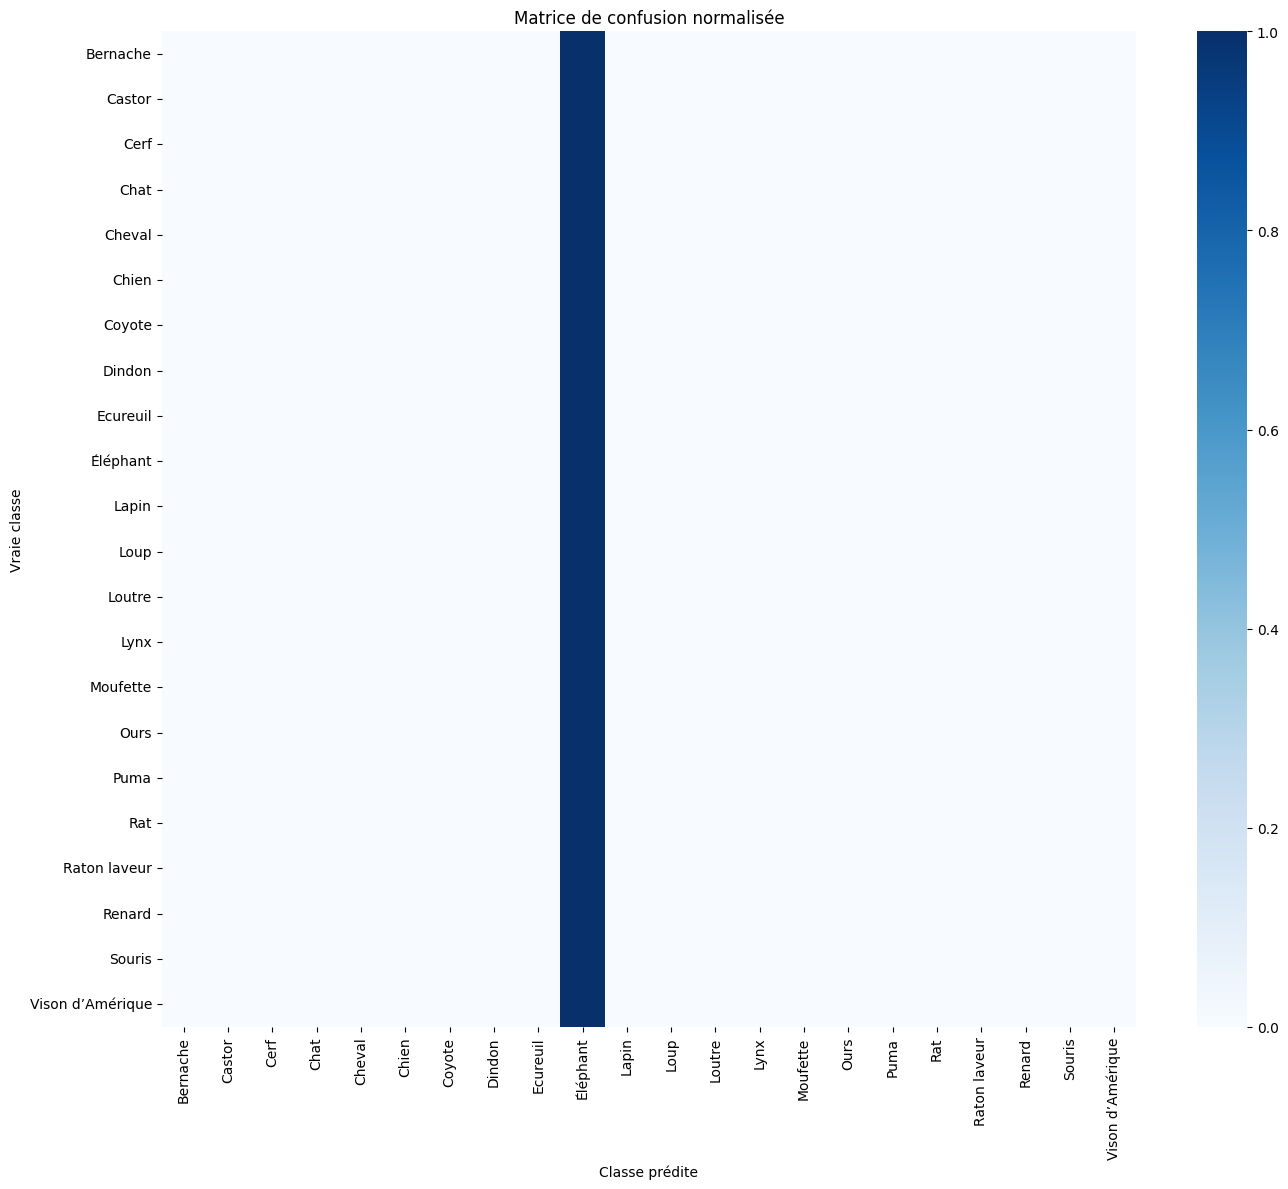

Top 10 des confusions entre classes:
  Ecureuil classifié comme Éléphant: 42 fois (100.0%)
  Raton laveur classifié comme Éléphant: 41 fois (100.0%)
  Ours classifié comme Éléphant: 39 fois (100.0%)
  Cerf classifié comme Éléphant: 33 fois (100.0%)
  Lynx classifié comme Éléphant: 29 fois (100.0%)
  Renard classifié comme Éléphant: 24 fois (100.0%)
  Coyote classifié comme Éléphant: 22 fois (100.0%)
  Dindon classifié comme Éléphant: 21 fois (100.0%)
  Moufette classifié comme Éléphant: 20 fois (100.0%)
  Puma classifié comme Éléphant: 20 fois (100.0%)


In [ ]:
def analyze_confusion_matrix(model, data_generator):
    """Analyse détaillée de la matrice de confusion."""
    # Réinitialiser le générateur
    data_generator.reset()
    
    # Prédictions
    y_pred = model.predict(data_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Vraies classes
    y_true = data_generator.classes[:len(y_pred_classes)]
    
    # Convertir les indices en noms de classes
    class_indices = data_generator.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}
    class_names = [idx_to_class[i] for i in range(len(class_indices))]
    
    # Calculer la matrice de confusion
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Normaliser la matrice
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Tracer la matrice
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.title('Matrice de confusion normalisée')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Identifier les paires de classes les plus confondues
    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((class_names[i], class_names[j], cm[i, j], cm_normalized[i, j]))
    
    # Trier par nombre d'erreurs
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Afficher les 10 paires les plus problématiques
    print("Top 10 des confusions entre classes:")
    for true_class, pred_class, count, ratio in confusion_pairs[:10]:
        print(f"  {true_class} classifié comme {pred_class}: {count} fois ({ratio*100:.1f}%)")

# Analyser les confusions
analyze_confusion_matrix(model, test_generator)